# Part 2 : Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline

## Data Loading

In [2]:
train = pd.read_csv('train_selected.csv')
train.head()

,id,cycle,s1,s2,s3,s4,ttf,label_bnc
0,1,1,1400.60,554.36,47.47,521.66,191,0
1,1,2,1403.14,553.75,47.49,522.28,190,0
2,1,3,1404.20,554.26,47.27,522.42,189,0
3,1,4,1401.87,554.45,47.13,522.86,188,0
4,1,5,1406.22,554.00,47.28,522.19,187,0


In [3]:
test = pd.read_csv('test_selected.csv')
test.head()

,id,cycle,s1,s2,s3,s4
0,1,31,1398.91,554.42,47.23,521.79
1,2,49,1410.83,553.52,47.67,521.74
2,3,126,1418.89,552.59,47.88,520.83
3,4,106,1406.88,552.64,47.65,521.88
4,5,98,1419.36,553.29,47.46,521.00


## Data Preparation and Visualization

In [4]:
X_train = train[['cycle','s1','s2','s3','s4']]
y_train = train['label_bnc']

X_test = test[['cycle','s1','s2','s3','s4']]

y_test_prev = pd.read_csv('PM_truth.txt') 
print(y_test_prev)
y_test_prev = np.asarray(y_test_prev)[0:len(y_test_prev),0]

# Assign the label class for each value of TTF
y_test=np.zeros(len(y_test_prev))
for i in range(len(y_test_prev)):
    if y_test_prev[i]<=30:
        y_test[i]=1 # Class 1 if TTF<=30
    else:
        y_test[i]=0 # Class 0 if TTF>30
print(y_test)

    y_test
0      112
1       98
2       69
3       82
4       91
..     ...
95     137
96      82
97      59
98     117
99      20

[100 rows x 1 columns]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 1.]


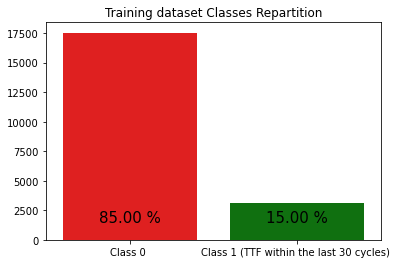

In [5]:
# Class Repartition Visualization by histogram 

# Class 1 if TTF<=30
# Class 0 if TTF>30

names = ['Class 0 ', 'Class 1 (TTF within the last 30 cycles) '] 
values = [(y_train == 0).sum(),(y_train == 1).sum()]
graph = sns.barplot(x=names, y=values, palette=['red','green'])
graph.set_title("Training dataset Classes Repartition")
for k in range(2) :
    graph.text(k, 1500, "%.2f %s" % (round(values[k]/sum(values)*100), "%"), fontsize=15, ha = 'center')
    

## Classifier tuning 

In [6]:
# Perfor Grid Search hyper parameter tuning 

def bin_classify(model, clf, features, params=None, score=None):
    
    """
    Args:
        model (str): The model name identifier
        clf (clssifier object): The classifier to be tuned
        features (list): The set of input features names
        params (dict): Grid Search parameters
        score (str): Grid Search score
        
    Returns:
        Tuned Clssifier object
        dataframe of model predictions and scores 
    """
    
    grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    if hasattr(grid_search, 'predict_proba'):   
        y_score = grid_search.predict_proba(X_test)[:,1]
    elif hasattr(grid_search, 'decision_function'):
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred
        
    predictions = {'y_pred' : y_pred, 'y_score' : y_score}
    df_predictions = pd.DataFrame.from_dict(predictions)
    
    return grid_search.best_estimator_, df_predictions

## Generic function plotting metrics results

In [7]:
# Calculate main binary classifcation metrics, plot AUC ROC and Precision-Recall curves

def bin_class_metrics(model, y_test, y_pred, y_score, print_out=True, plot_out=True):
    
    """  
    Args:
        model (str): The model name identifier
        y_test (series): Contains the test label values
        y_pred (series): Contains the predicted values
        y_score (series): Contains the predicted scores
        print_out (bool): Print the classification metrics and thresholds values
        plot_out (bool): Plot AUC ROC, Precision-Recall, and Threshold curves
        
    Returns:
        dataframe: The combined metrics in single dataframe
        dataframe: ROC thresholds
        dataframe: Precision-Recall thresholds
        Plot: AUC ROC
        plot: Precision-Recall
        plot: Precision-Recall threshold; also show the number of engines predicted for maintenace per period (queue).
        plot: TPR-FPR threshold    
    """
      
    binclass_metrics = {
                        'Precision' : metrics.precision_score(y_test, y_pred),
                        'Recall' : metrics.recall_score(y_test, y_pred),
                        'F1 Score' : metrics.f1_score(y_test, y_pred),
                        'ROC / AUC' : metrics.roc_auc_score(y_test, y_score)
                       }
    
    df_metrics = pd.DataFrame.from_dict(binclass_metrics, orient='index')
    df_metrics.columns = [model]  


    fpr, tpr, thresh_roc = metrics.roc_curve(y_test, y_score)
    
    roc_auc = metrics.auc(fpr, tpr)

    engines_roc = []  
    for thr in thresh_roc:  
        engines_roc.append((y_score >= thr).mean())

    engines_roc = np.array(engines_roc)

    roc_thresh = {
                    'Threshold' : thresh_roc,
                    'TPR' : tpr,
                    'FPR' : fpr,
                    'Que' : engines_roc
                 }
    
    df_roc_thresh = pd.DataFrame.from_dict(roc_thresh)
    
    #calculate other classification metrics: TP, FP, TN, FN, TNR, FNR
    #from ground truth file, positive class = 25 => TP + FN = 25
    #from ground truth file, negative class = 75 => TN + FP = 75
    
    df_roc_thresh['TP'] = (25*df_roc_thresh.TPR).astype(int)
    df_roc_thresh['FP'] = (25 - (25*df_roc_thresh.TPR)).astype(int)
    df_roc_thresh['TN'] = (75*(1 - df_roc_thresh.FPR)).astype(int)
    df_roc_thresh['FN'] = (75 - (75*(1 - df_roc_thresh.FPR))).astype(int)
    
    df_roc_thresh['TNR'] = df_roc_thresh['TN']/(df_roc_thresh['TN'] + df_roc_thresh['FN'])
    df_roc_thresh['FNR'] = df_roc_thresh['TN']/(df_roc_thresh['TN'] + df_roc_thresh['FP'])
    
    df_roc_thresh['Model'] = model
    
    
    precision, recall, thresh_prc = metrics.precision_recall_curve(y_test, y_score)

    thresh_prc = np.append(thresh_prc,1)

    engines_prc = []  
    for thr in thresh_prc:  
        engines_prc.append((y_score >= thr).mean())

    engines_prc = np.array(engines_prc)

    prc_thresh = {
                    'Threshold' : thresh_prc,
                    'Precision' : precision,
                    'Recall' : recall,
                    'Que' : engines_prc
                 }
    
    
    df_prc_thresh = pd.DataFrame.from_dict(prc_thresh)

    if print_out:
        print('-----------------------------------------------------------')
        print(model, '\n')
        print('Confusion Matrix:')
        print(metrics.confusion_matrix(y_test, y_pred))
        print('\nClassification Report:')
        print(metrics.classification_report(y_test, y_pred))
        print('\nMetrics:')
        print(df_metrics)

        print('\nROC Thresholds:\n')
        print(df_roc_thresh[['Threshold', 'TP', 'FP', 'TN', 'FN', 'TPR', 'FPR', 'TNR','FNR', 'Que']])

        print('\nPrecision-Recall Thresholds:\n')
        print(df_prc_thresh[['Threshold', 'Precision', 'Recall', 'Que']])
        
        
    if plot_out:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False )
        fig.set_size_inches(10,10)

        ax1.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f'% roc_auc)
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([-0.05, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title('ROC/AUC')
        ax1.legend(loc="lower right", fontsize='small')

        ax2.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_title('Precision Recall curve')
        ax2.legend(loc="lower left", fontsize='small')

        ax3.plot(thresh_roc, fpr, color='red', lw=2, label='FPR : False Positive Rate')  
        ax3.plot(thresh_roc, tpr, color='green',label='TPR : True Positive Rate') 
        ax3.plot(thresh_roc, engines_roc, color='blue',label='Engines to maintain') 
        ax3.set_ylim([0.0, 1.05])
        ax3.set_xlim([0.0, 1])
        ax3.set_xlabel('Threshold')  
        ax3.set_ylabel('%')
        ax3.set_title('FPR and TPR over threshold')
        ax3.legend(loc='upper right', fontsize='small')

        ax4.plot(thresh_prc, precision, color='red', lw=2, label='Precision')  
        ax4.plot(thresh_prc, recall, color='green',label='Recall') 
        ax4.plot(thresh_prc, engines_prc, color='blue',label='Engines to maintain') 
        ax4.set_ylim([0.0, 1.05])
        ax4.set_xlabel('Threshold')  
        ax4.set_ylabel('%')
        ax4.set_title('Precision, recall and proportion of failing engines over threshold')
        ax4.legend(loc='lower left', fontsize='small')

    return  df_metrics, df_roc_thresh, df_prc_thresh

## Logistic Regression


Best Parameters:
 LogisticRegression(C=10, random_state=123)
-----------------------------------------------------------
Logistic Regression 

Confusion Matrix:
[[73  2]
 [ 8 17]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.94        75
         1.0       0.89      0.68      0.77        25

    accuracy                           0.90       100
   macro avg       0.90      0.83      0.85       100
weighted avg       0.90      0.90      0.90       100


Metrics:
           Logistic Regression
Precision             0.894737
Recall                0.680000
F1 Score              0.772727
ROC / AUC             0.960000

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    1.990494   0  25  75   0  0.00  0.000000  1.000000  0.750000  0.00
1    0.990494   1  24  75   0  0.04  0.000000  1.000000  0.757576  0.01
2    0.857659  10  15  75   0  0.40  0.000000  1.000000  0.833333  0.

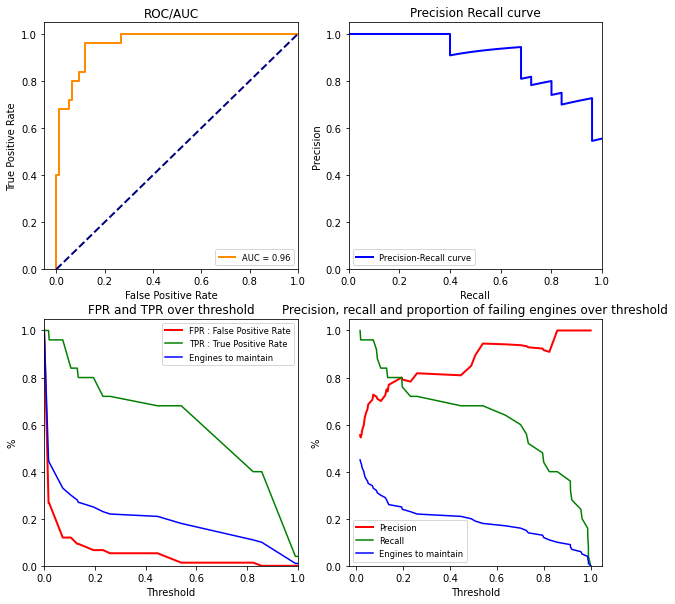

In [8]:
# Tuning for Logistic Regression

features_orig = ['cycle','s1','s2','s3','s4']
model = 'Logistic Regression'
clf_lgrb = LogisticRegression(random_state=123)
gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'

clf_lgrb, pred_lgrb = bin_classify(model, clf_lgrb, features_orig, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_lgrb)

metrics_lgrb, roc_lgrb, prc_lgrb = bin_class_metrics(model, y_test, pred_lgrb.y_pred, pred_lgrb.y_score, print_out=True, plot_out=True)

In [9]:
# Results for each metric

metrics_lgr = pd.concat([metrics_lgrb], axis=1)
metrics_lgr

,Logistic Regression
Precision,0.894737
Recall,0.680000
F1 Score,0.772727
ROC / AUC,0.960000


In [10]:
# Preview of an extract of predictions  

print(pred_lgrb.y_pred[30:40])
print(pd.Series(y_test[30:40]))

30    1
31    0
32    0
33    1
34    1
35    1
36    0
37    0
38    0
39    1
Name: y_pred, dtype: int64
0    1.0
1    0.0
2    0.0
3    1.0
4    1.0
5    1.0
6    1.0
7    0.0
8    0.0
9    1.0
dtype: float64


Text(0.5, 1.0, 'Classification prediction of TTF - Logistic Regression')

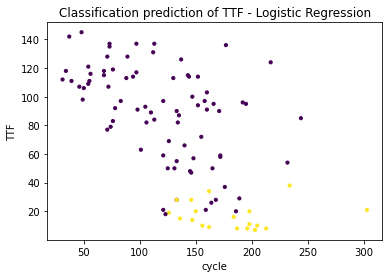

In [11]:
# Plot predicted classes for TTF for Logistic Regression
y_test1 = pd.read_csv('PM_truth.txt')
plt.scatter(X_test[['cycle']], y_test1, c=pred_lgrb.y_pred, s = 10)
plt.xlabel('cycle')
plt.ylabel('TTF')
plt.title('Classification prediction of TTF - Logistic Regression')

C:\Users\clair\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


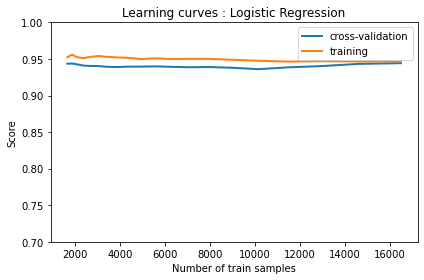

In [12]:
# Cross validation for Logistic Regression

model = make_pipeline(LogisticRegression(C=10, random_state=123))
train_sizes, train_scores, validation_scores = learning_curve(model, X_train, y_train, train_sizes=np.logspace(-1, 0, 20))

# Plot the mean train error and validation error across folds
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, validation_scores.mean(axis=1), lw=2, label='cross-validation')
plt.plot(train_sizes, train_scores.mean(axis=1), lw=2, label='training')
plt.ylim(ymin=-.1, ymax=1)

plt.legend(loc='best')
plt.xlabel('Number of train samples')
plt.ylim(0.7,1)
plt.ylabel('Score')
plt.title('Learning curves : Logistic Regression')
plt.tight_layout()
plt.show()

In [13]:
# Results with a new threshold (0.08 instead of 0.5)

THRESHOLD = 0.08
preds = np.where(clf_lgrb.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
print(preds)

results = {
                        'Precision' : metrics.precision_score(y_test, preds),
                        'Recall' : metrics.recall_score(y_test, preds),
                        'F1 Score' : metrics.f1_score(y_test, preds)
                       }

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1
 0 0 1 1 1 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0
 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1]


## Random Forest


Best Parameters:
 RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=50,
                       random_state=123)
-----------------------------------------------------------
Random Forest 

Confusion Matrix:
[[73  2]
 [ 8 17]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.94        75
         1.0       0.89      0.68      0.77        25

    accuracy                           0.90       100
   macro avg       0.90      0.83      0.85       100
weighted avg       0.90      0.90      0.90       100


Metrics:
           Random Forest
Precision       0.894737
Recall          0.680000
F1 Score        0.772727
ROC / AUC       0.964267

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    1.998909   0  25  75   0  0.00  0.000000  1.000000  0.750000  0.00
1    0.998909   1  24  75   0  0.04  0.000000  1.000000  0.757576  0.01
2    0.670498  14  10  75   0  0.

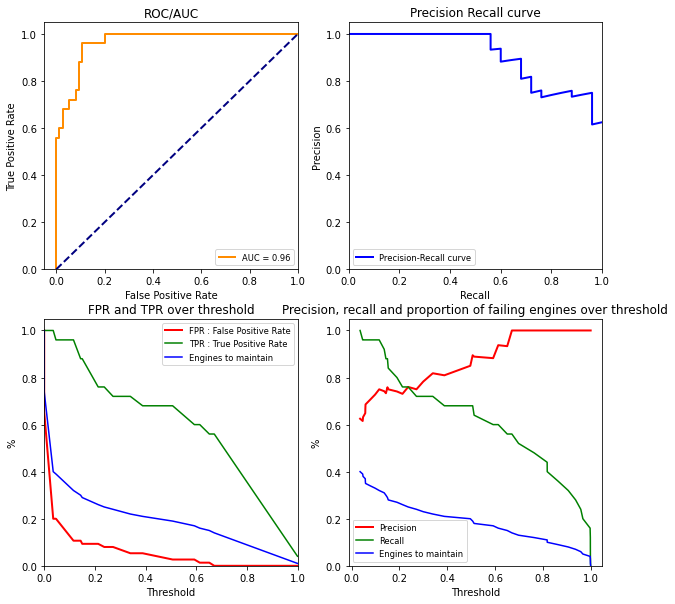

In [14]:
# Tuning for Random Forest Classifier

model = 'Random Forest'
clf_rfcb = RandomForestClassifier(n_estimators=50, random_state=123)
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'

clf_rfcb, pred_rfcb = bin_classify(model, clf_rfcb, features_orig, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_rfcb)

metrics_rfcb, roc_rfcb, prc_rfcb = bin_class_metrics(model, y_test, pred_rfcb.y_pred, pred_rfcb.y_score, print_out=True, plot_out=True)

In [15]:
# Results for each metric

metrics_rfc = pd.concat([metrics_rfcb], axis=1)
metrics_rfc

,Random Forest
Precision,0.894737
Recall,0.680000
F1 Score,0.772727
ROC / AUC,0.964267


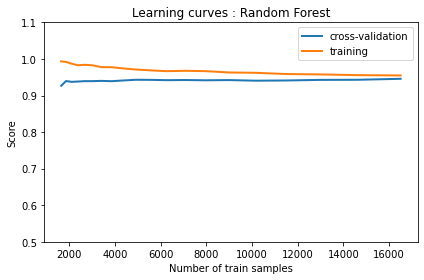

In [16]:
# Cross validation for Random Forest Classifier

model = make_pipeline(RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=50,
                       random_state=123))
train_sizes, train_scores, validation_scores = learning_curve(model, X_train, y_train, train_sizes=np.logspace(-1, 0, 20))

# Plot the mean train error and validation error across folds
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, validation_scores.mean(axis=1), lw=2, label='cross-validation')
plt.plot(train_sizes, train_scores.mean(axis=1), lw=2, label='training')
plt.ylim(ymin=-.1, ymax=1)

plt.legend(loc='best')
plt.xlabel('Number of train samples')
plt.ylabel('Score')
plt.ylim(0.5,1.1)
plt.title('Learning curves : Random Forest')
plt.tight_layout()
plt.show()

## SVC Linear

C:\Users\clair\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



Best Parameters:
 LinearSVC(random_state=123)
-----------------------------------------------------------
SVC Linear 

Confusion Matrix:
[[67  8]
 [ 5 20]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91        75
         1.0       0.71      0.80      0.75        25

    accuracy                           0.87       100
   macro avg       0.82      0.85      0.83       100
weighted avg       0.88      0.87      0.87       100


Metrics:
           SVC Linear
Precision    0.714286
Recall       0.800000
F1 Score     0.754717
ROC / AUC    0.952000

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    2.578923   0  25  75   0  0.00  0.000000  1.000000  0.750000  0.00
1    1.578923   1  24  75   0  0.04  0.000000  1.000000  0.757576  0.01
2    0.722076  11  14  75   0  0.44  0.000000  1.000000  0.842697  0.11
3    0.622385  11  14  74   1  0.44  0.013333  0.986667  0.840909 

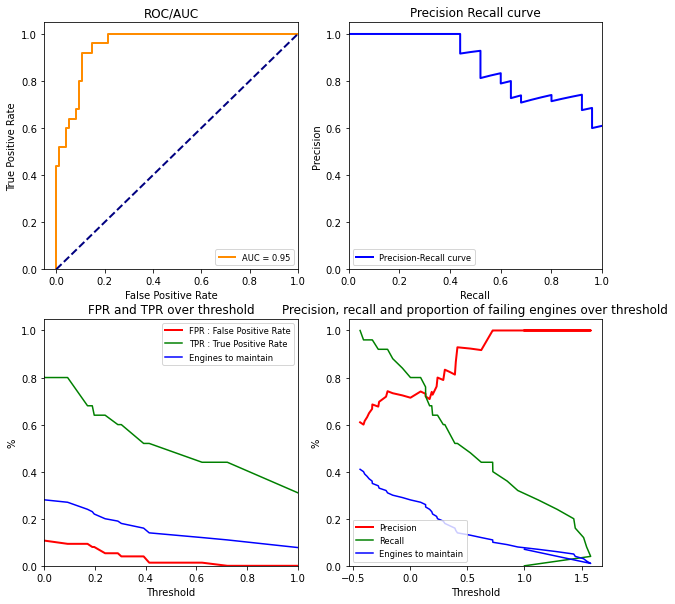

In [17]:
# Tuning for SVC Linear

model = 'SVC Linear'
clf_svlb = LinearSVC(random_state=123)
gs_params = {'C': [.01 ,.1 ,1.0]}
gs_score = 'roc_auc'

clf_svlb, pred_svlb = bin_classify(model, clf_svlb, features_orig, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_svlb)

metrics_svlb, roc_svlb, prc_svlb = bin_class_metrics(model, y_test, pred_svlb.y_pred, pred_svlb.y_score, print_out=True, plot_out=True)

In [18]:
# Results for each metric
metrics_svl = pd.concat([metrics_svlb], axis=1)
metrics_svl.sort_index()

,SVC Linear
F1 Score,0.754717
Precision,0.714286
ROC / AUC,0.952000
Recall,0.800000


## KNN


Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=13)
-----------------------------------------------------------
KNN 

Confusion Matrix:
[[73  2]
 [13 12]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.97      0.91        75
         1.0       0.86      0.48      0.62        25

    accuracy                           0.85       100
   macro avg       0.85      0.73      0.76       100
weighted avg       0.85      0.85      0.83       100


Metrics:
                KNN
Precision  0.857143
Recall     0.480000
F1 Score   0.615385
ROC / AUC  0.929067

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    2.000000   0  25  75   0  0.00  0.000000  1.000000  0.750000  0.00
1    1.000000   4  21  75   0  0.16  0.000000  1.000000  0.781250  0.04
2    0.846154   6  19  75   0  0.24  0.000000  1.000000  0.797872  0.06
3    0.769231   8  17  75   0  0.32  0.000000  1.000000  0.8152

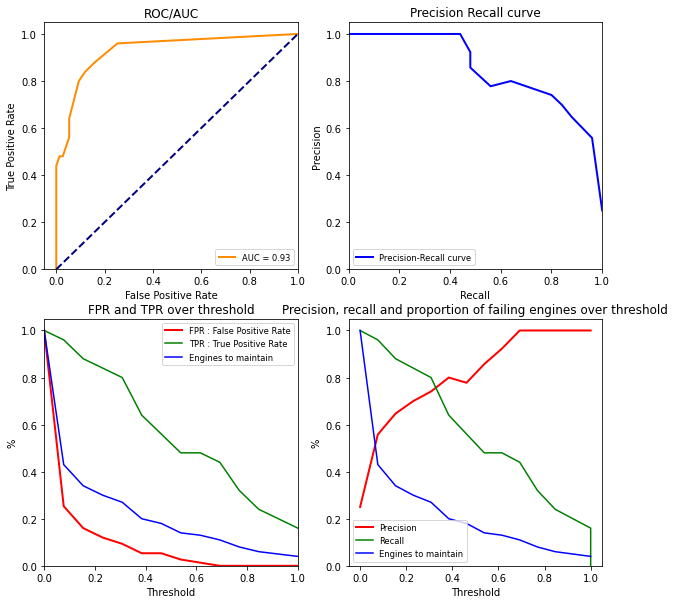

In [19]:
# Tuning for KNN

model = 'KNN'
clf_knnb = KNeighborsClassifier(n_jobs=-1)
gs_params = {'n_neighbors': [9, 10, 11, 12, 13]}
gs_score = 'roc_auc'

clf_knnb, pred_knnb = bin_classify(model, clf_knnb, features_orig, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_knnb)

metrics_knnb, roc_knnb, prc_knnb = bin_class_metrics(model, y_test, pred_knnb.y_pred, pred_knnb.y_score, print_out=True, plot_out=True)

In [20]:
# Results for each metric

metrics_knn = pd.concat([metrics_knnb], axis=1)
metrics_knn.sort_index()

,KNN
F1 Score,0.615385
Precision,0.857143
ROC / AUC,0.929067
Recall,0.480000


## Gaussian NB


Best Parameters:
 GaussianNB()
-----------------------------------------------------------
Gaussian NB 

Confusion Matrix:
[[69  6]
 [ 7 18]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91        75
         1.0       0.75      0.72      0.73        25

    accuracy                           0.87       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.87      0.87      0.87       100


Metrics:
           Gaussian NB
Precision     0.750000
Recall        0.720000
F1 Score      0.734694
ROC / AUC     0.958933

ROC Thresholds:

       Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0   2.000000e+00   0  25  75   0  0.00  0.000000  1.000000  0.750000  0.00
1   1.000000e+00   1  24  75   0  0.04  0.000000  1.000000  0.757576  0.01
2   9.999440e-01  12  13  75   0  0.48  0.000000  1.000000  0.852273  0.12
3   9.997120e-01  12  13  74   1  0.48  0.013333  0.986667  0.8

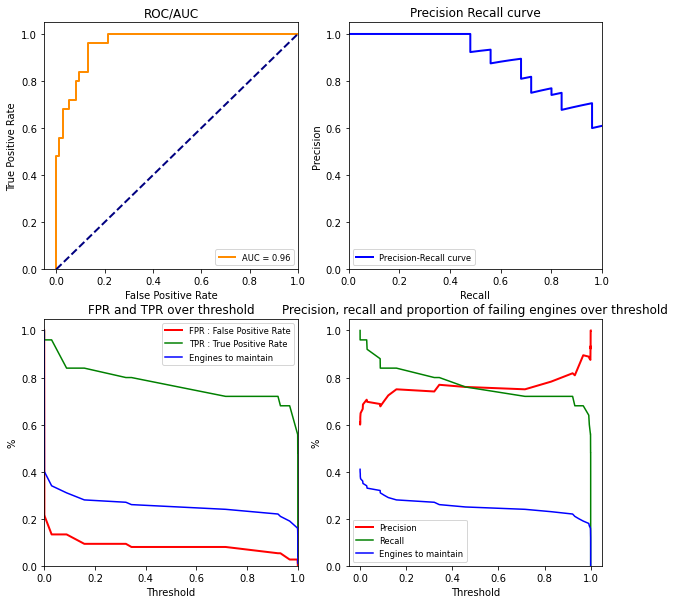

In [21]:
# Tuning for Gaussian NB

model = 'Gaussian NB'
clf_gnbb = GaussianNB()
gs_params = {} 
gs_score = 'roc_auc'

clf_gnbb, pred_gnbb = bin_classify(model, clf_gnbb, features_orig, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_gnbb)

metrics_gnbb, roc_gnbb, prc_gnbb = bin_class_metrics(model, y_test, pred_gnbb.y_pred, pred_gnbb.y_score, print_out=True, plot_out=True)

In [22]:
# Results for each metric

metrics_gnb = pd.concat([metrics_gnbb], axis=1)
metrics_gnb.sort_index()

,Gaussian NB
F1 Score,0.734694
Precision,0.750000
ROC / AUC,0.958933
Recall,0.720000


## Results summary

In [23]:
# Compare all models

metrics_bn = pd.concat([metrics_lgr, metrics_rfc, metrics_svl, metrics_knn, metrics_gnb], axis=1)
metrics_bn

,Logistic Regression,Random Forest,SVC Linear,KNN,Gaussian NB
Precision,0.894737,0.894737,0.714286,0.857143,0.750000
Recall,0.680000,0.680000,0.800000,0.480000,0.720000
F1 Score,0.772727,0.772727,0.754717,0.615385,0.734694
ROC / AUC,0.960000,0.964267,0.952000,0.929067,0.958933


Text(0.5, 1.0, 'Precision Recall Curve')

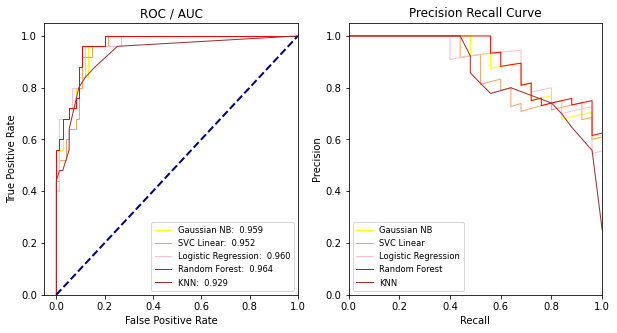

In [24]:
# Plot AUC-ROC and precision-recall curves for models

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False )
fig.set_size_inches(10,5)

ax1.plot(roc_gnbb.FPR, roc_gnbb.TPR, color='yellow', lw=1, label= metrics_gnbb.columns.values.tolist()[0] + ':  %.3f' % metrics_gnbb.at['ROC / AUC', metrics_gnbb.columns.values.tolist()[0]])
ax1.plot(roc_svlb.FPR, roc_svlb.TPR, color='sandybrown', lw=1, label= metrics_svlb.columns.values.tolist()[0] + ':  %.3f' % metrics_svlb.at['ROC / AUC', metrics_svlb.columns.values.tolist()[0]])

ax1.plot(roc_lgrb.FPR, roc_lgrb.TPR, color='pink', lw=1, label= metrics_lgrb.columns.values.tolist()[0] + ':  %.3f' % metrics_lgrb.at['ROC / AUC', metrics_lgrb.columns.values.tolist()[0]])
ax1.plot(roc_rfcb.FPR, roc_rfcb.TPR, color='red', lw=1, label= metrics_rfcb.columns.values.tolist()[0] + ':  %.3f' % metrics_rfcb.at['ROC / AUC', metrics_rfcb.columns.values.tolist()[0]])
ax1.plot(roc_knnb.FPR, roc_knnb.TPR, color='brown', lw=1, label= metrics_knnb.columns.values.tolist()[0] + ':  %.3f' % metrics_knnb.at['ROC / AUC', metrics_knnb.columns.values.tolist()[0]])


ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([-0.05, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right", fontsize='small')
ax1.set_title('ROC / AUC')

ax2.plot(prc_gnbb.Recall, prc_gnbb.Precision, color='yellow', lw=1, label= metrics_gnbb.columns.values.tolist()[0])
ax2.plot(prc_svlb.Recall, prc_svlb.Precision, color='sandybrown', lw=1, label= metrics_svlb.columns.values.tolist()[0])

ax2.plot(prc_lgrb.Recall, prc_lgrb.Precision, color='pink', lw=1, label= metrics_lgrb.columns.values.tolist()[0])
ax2.plot(prc_rfcb.Recall, prc_rfcb.Precision, color='red', lw=1, label= metrics_rfcb.columns.values.tolist()[0])
ax2.plot(prc_knnb.Recall, prc_knnb.Precision, color='brown', lw=1, label= metrics_knnb.columns.values.tolist()[0])


ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc="lower left", fontsize='small')
ax2.set_title('Precision Recall Curve')